Total files: 832
Extracted MFCC features shape: (4884, 3380)
Labels shape: (4884,)
Unique class labels: [0 1]


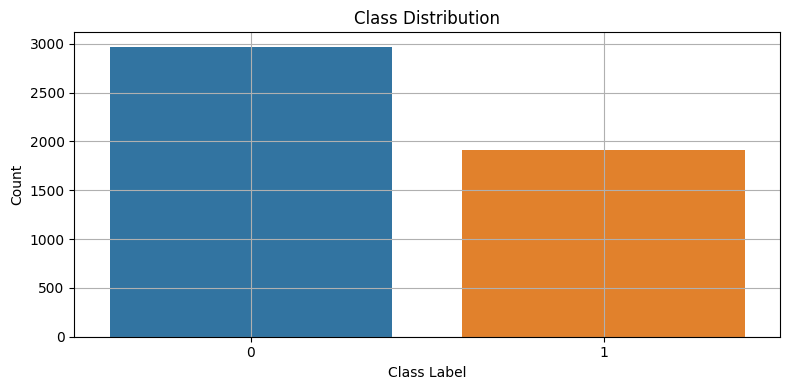

In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
import seaborn as sns

def butter_bandpass_filter(data, lowcut=25.0, highcut=400.0, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def get_binary_label(fname):
    fname = fname.lower()
    if "normal" in fname:
        return 0  # Normal
    elif any(x in fname for x in ["murmur", "artifact", "extrahls"]):
        return 1  # Abnormal
    else:
        return None

def extract_mfcc(cycle, sr, n_mfcc=13, max_len=260):
    mfcc = librosa.feature.mfcc(y=cycle.astype(np.float32), sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=128)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

# Load and Process Data
base_path = "/kaggle/input/heartbeat-sounds"
data_dirs = [os.path.join(base_path, "set_a"), os.path.join(base_path, "set_b")]
all_files = [file for folder in data_dirs for file in glob.glob(os.path.join(folder, "*.wav"))]

X_features = []
y_labels = []

for file_path in all_files:
    audio, sr = librosa.load(file_path, sr=None)
    if sr != 1000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=1000)
        sr = 1000

    audio = audio / np.max(np.abs(audio))
    filtered_audio = butter_bandpass_filter(audio, fs=sr)
    envelope = np.abs(hilbert(filtered_audio))
    peaks, _ = find_peaks(envelope, distance=int(0.4 * sr), height=np.mean(envelope) * 1.2)

    cardiac_cycles = []
    if len(peaks) >= 3:
        for i in range(len(peaks) - 2):
            start, end = peaks[i], peaks[i + 2]
            if end > start:
                cycle = filtered_audio[start:end]
                cardiac_cycles.append(cycle)

    label = get_binary_label(file_path)
    if label is not None:
        for cycle in cardiac_cycles:
            mfcc = extract_mfcc(cycle, sr)
            X_features.append(mfcc.flatten())
            y_labels.append(label)

X = np.array(X_features)
y = np.array(y_labels)
print(f"Total files: {len(all_files)}")
print(f"Extracted MFCC features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Unique class labels: {np.unique(y)}")

# Class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Train/Test Split and Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Fitting 5 folds for each of 248 candidates, totalling 1240 fits

 RF GridSearch Training Time: 20403.4371 seconds
 Best RF Parameters: {'max_depth': None, 'n_estimators': 900}

 RF Test Inference Time: 0.3337 seconds
 RF Test Accuracy: 0.8188331627430911
 RF Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87       594
           1       0.90      0.60      0.72       383

    accuracy                           0.82       977
   macro avg       0.85      0.78      0.79       977
weighted avg       0.83      0.82      0.81       977

 RF Confusion Matrix:
 [[569  25]
 [152 231]]


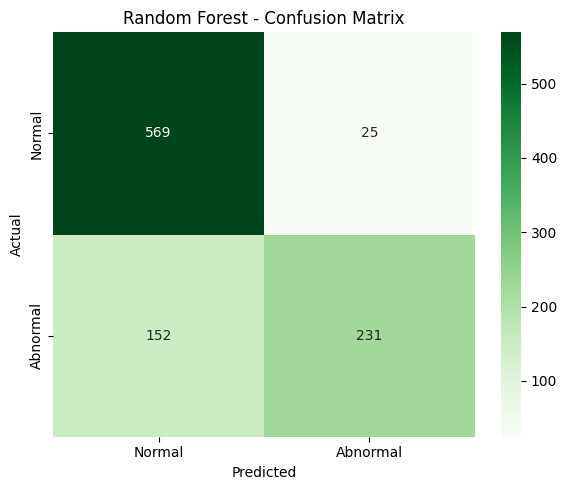


 RF Accuracy & Recall for Each Param Combo:
{'max_depth': None, 'n_estimators': 100} => Accuracy: 0.8229, Recall: 0.6057
{'max_depth': None, 'n_estimators': 200} => Accuracy: 0.8199, Recall: 0.6005
{'max_depth': None, 'n_estimators': 300} => Accuracy: 0.8158, Recall: 0.5901
{'max_depth': None, 'n_estimators': 400} => Accuracy: 0.8178, Recall: 0.6005
{'max_depth': None, 'n_estimators': 500} => Accuracy: 0.8219, Recall: 0.6031
{'max_depth': None, 'n_estimators': 600} => Accuracy: 0.8168, Recall: 0.6031
{'max_depth': None, 'n_estimators': 700} => Accuracy: 0.8209, Recall: 0.6057
{'max_depth': None, 'n_estimators': 800} => Accuracy: 0.8209, Recall: 0.6057
{'max_depth': None, 'n_estimators': 900} => Accuracy: 0.8188, Recall: 0.6031
{'max_depth': None, 'n_estimators': 1000} => Accuracy: 0.8178, Recall: 0.5979
{'max_depth': None, 'n_estimators': 1100} => Accuracy: 0.8188, Recall: 0.6031
{'max_depth': None, 'n_estimators': 1200} => Accuracy: 0.8219, Recall: 0.6084
{'max_depth': None, 'n_estim

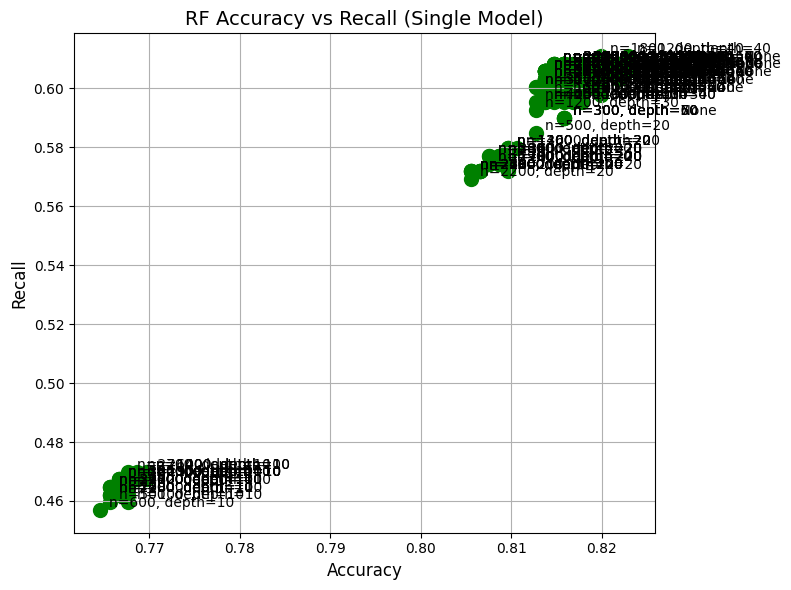

In [2]:
# --- RF Param Grid 
rf_param_grid = {
    'n_estimators': list(range(100, 3101, 100)),
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70]
}

# --- Grid Search ---
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# --- Training Time ---
start_train = time.time()
rf_grid.fit(X_train, y_train)
end_train = time.time()

print(f"\n RF GridSearch Training Time: {end_train - start_train:.4f} seconds")
print(" Best RF Parameters:", rf_grid.best_params_)

# --- Best Model ---
best_rf = rf_grid.best_estimator_

# --- Inference ---
start_test = time.time()
rf_pred = best_rf.predict(X_test)
end_test = time.time()

print(f"\n RF Test Inference Time: {end_test - start_test:.4f} seconds")
print(" RF Test Accuracy:", accuracy_score(y_test, rf_pred))
print(" RF Classification Report:\n", classification_report(y_test, rf_pred))
# --- Confusion Matrix ---
cm_rf = confusion_matrix(y_test, rf_pred)
print(" RF Confusion Matrix:\n", cm_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Normal", "Abnormal"],
            yticklabels=["Normal", "Abnormal"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Accuracy vs Recall for this one combo ---
rf_results = []
print("\n RF Accuracy & Recall for Each Param Combo:")
for params in rf_grid.cv_results_['params']:
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    rf_results.append((acc, rec, params))
    print(f"{params} => Accuracy: {acc:.4f}, Recall: {rec:.4f}")

# --- Scatter Plot: Accuracy vs Recall ---
plt.figure(figsize=(8, 6))
for acc, rec, params in rf_results:
    label = f"n={params['n_estimators']}, depth={params['max_depth']}"
    plt.scatter(acc, rec, s=100, color='green')
    plt.text(acc + 0.001, rec + 0.001, label, fontsize=10)

plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.title("RF Accuracy vs Recall (Single Model)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
